### **All content was referenced in Paul Dnt (https://www.kaggle.com/pednt9/gwd-keras-unet-starter/output)**
# 
This is my first competition and this notebook was made for my study.

2020/07/27 혜주 공부자료

### Import libraries

In [ ]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.measure import label, regionprops
from PIL import Image, ImageDraw
from ast import literal_eval
from tqdm.notebook import tqdm

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras import backend as K

### Reading data

In [ ]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512

TRAIN_PATH = '/kaggle/input/global-wheat-detection/train/'
TEST_PATH = '/kaggle/input/global-wheat-detection/test/'
SC_FACTOR = int(1024 / IMG_WIDTH)

warnings.filterwarnings('ignore')
seed = 42
random.seed = seed
np.random.seed = seed

In [ ]:
PATH = "../input/global-wheat-detection/"
train_folder = os.path.join(PATH, "train")
test_folder = os.path.join(PATH, "test")

train_csv_path = os.path.join(PATH, "train.csv")
df = pd.read_csv(train_csv_path)
sample_sub = pd.read_csv(PATH + "sample_submission.csv")

df.head()

In [ ]:
# Get train and test IDs and paths
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

### Convert multiple bounding boxes to masks

* bbox부분을 mask로 채우는 과정이다.
* 이미지 크기를 반으로 줄일 것이므로 bbox의 좌표도 반으로 줄여주고 3373개의 이미지에 대해서 모두 polygon을 그린다.
* masks는 dict로 3373개의 이미지에 대해서 512,512 짜리 0과 1로 polygon이 표시된 array이다.

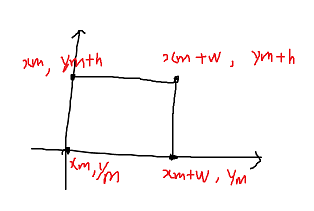

In [ ]:
def make_polygon(coords):
    xm, ym, w, h = coords
    xm, ym, w, h = xm / SC_FACTOR, ym / SC_FACTOR, w / SC_FACTOR, h / SC_FACTOR   # scale values if image was downsized
    return [(xm, ym), (xm, ym + h), (xm + w, ym + h), (xm + w, ym)]

In [ ]:
masks = dict() # dictionnary containing all masks

for img_id, gp in tqdm(df.groupby("image_id")):
    gp['polygons'] = gp['bbox'].apply(eval).apply(lambda x: make_polygon(x))

    img = Image.new('L', (IMG_WIDTH, IMG_HEIGHT), 0)
    for pol in gp['polygons'].values:
        ImageDraw.Draw(img).polygon(pol, outline=1, fill=1)

    mask = np.array(img, dtype=np.uint8)
    masks[img_id] = mask

In [ ]:
# 하나만 찍어보기
masks['00333207f']

In [ ]:
list(masks.keys())[0]

In [ ]:
im = Image.fromarray(masks[list(masks.keys())[0]])
plt.imshow(im)

### Train and Test data

* train data와 test data를 만든다.
* train data는 X_train과 Y_train으로 이루어지는데, 
* 먼저 X_train은 0으로 이루어진 512,512 3채널 짜리 배열을 만든다. Y_train은 False로 이루어진 512,512 1채널짜리 배열을 만든다
* 그 다음 X_train에는 학습 이미지를 불러와서 사이즈 조정해서 넣고, Y_train에는 masks를 불러와서 축을 하나더 추가한다. (512,512) --> (512,512,1) 
* 그러면 X_train에는 각 이미지마다 0~255 사이 값들이 512,512 3채널 짜리 배열이 되고, Y_train에는 이미지마다 0과 1로 이루어졌던 masks값들이 True, False 값들로 변하여 512,512 1채널 짜리 배열로 저장이 된다.
* X_test도 0으로 이루어진 512,512 3채널 짜리 배열을 만들어주고, X_test에 테스트 이미지를 불러와서 사이즈 조정해서 넣는다.

*즉 정리해보면 모델에는 X_train(원본이미지)와 Y_train(maskes)가 들어가는 것이다. 원본 이미지의 숫자들을 보고 이게 makes일지 아닐지를 구별하게 되는 것인 것 같다.

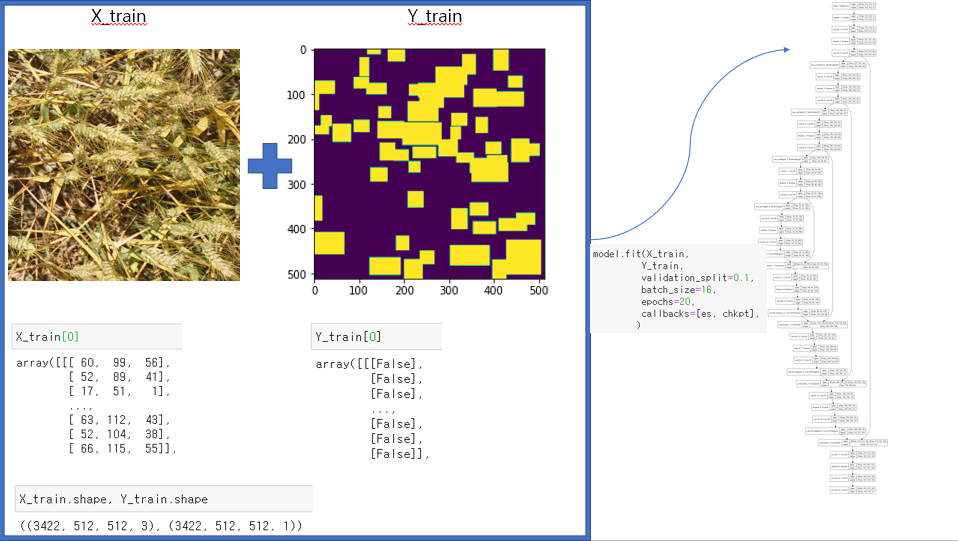

In [ ]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks... ')
#sys.stdout.flush()

In [ ]:
len(train_ids)

In [ ]:
for n, id_ in tqdm(enumerate(train_ids[:]), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    id_clean = id_.split('.')[0]
    if id_clean in masks.keys():
        Y_train[n] = masks[id_clean][:, :, np.newaxis]

In [ ]:
#np.max(X_train)

In [ ]:
X_train.shape, Y_train.shape

In [ ]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
sizes_test = list()
print('Getting and resizing test images...')

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

In [ ]:
X_test.shape

### 이미지 몇 개 그려보기

In [ ]:
def show_images(images, num=2):
    
    images_to_show = np.random.choice(images, num)

    for image_id in images_to_show:

        image_path = os.path.join(train_folder, image_id + ".jpg")
        image = Image.open(image_path)

        # get all bboxes for given image in [xmin, ymin, width, height]
        bboxes = [literal_eval(box) for box in df[df['image_id'] == image_id]['bbox']]

        # visualize them
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:    
            draw.rectangle([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], width=3)

        plt.figure(figsize = (10,10))
        plt.imshow(image)
        plt.show()

In [ ]:
unique_images = df['image_id'].unique()
show_images(unique_images)

### Model

In [ ]:
#Credits to : https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63044

def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred):

    tresholds = [0.5 + (i * 0.05)  for i in range(5)]  #tresholds = [0.5, 0.55, 0.6, 0.65, 0.7]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [ ]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)  # rescale inputs

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[competitionMetric2])
model.summary()

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image('model.png')

In [ ]:
# Fit model
earlystop = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

#from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

#es = EarlyStopping(patience=5)
#chkpt = ModelCheckpoint(filepath='best_model_todate.hdf5', save_best_only=True, save_weights_only=True)

model.fit(X_train, 
         Y_train,
         validation_split=0.1,
         batch_size=16, 
         epochs=3, 
         callbacks=[earlystop],
        )

### Prediction

As X_test is already formatted, we can directly make a prediction
* preds는 각 test 이미지에 대해 예측해서 나온 픽셀 값들이다.
* masked_preds는 mask인지 아닌지를 Treu, False로 반환해준다.

In [ ]:
THRESH = 0.65

preds = model.predict(X_test)[:, :, :, 0]
masked_preds = preds > THRESH

In [ ]:
preds[0]

In [ ]:
masked_preds[0]

In [ ]:
preds.shape, masked_preds.shape

In [ ]:
n_rows = 3
f, ax = plt.subplots(n_rows, 3, figsize=(14, 10))

for j, idx in enumerate([4,5,6]):
    for k, kind in enumerate(['original', 'pred', 'masked_pred']):
        if kind == 'original':
            img = X_test[idx]
        elif kind == 'pred':
            img = preds[idx]
        elif kind == 'masked_pred':
            masked_pred = preds[idx] > THRESH
            img = masked_pred
        ax[j, k].imshow(img)

plt.tight_layout()

test 이미지와 예측된 mask를 그려보면 나쁘지 않게 맞춘 것을 알 수 있다.

### Convert masked predictions to several bouding boxes

* mask로 예측된 부분을 bbox로 바꾸는 과정이다.
* True, False로 이루어져있는 masked_preds 에서 연결된 영역을 레이블로 묶고 그 이미지의 속성을 측정한다.
* 이미지의 속성중에는 bbox라는 게 있는데 (ymin, xmin, ymax, xmax) 순이므로
* 원래 주어졌던 데이터 형식의 bbox로 만들어준다. (xmin, ymin, w, h)
* 마지막으로 1을 붙여서 구분해주면 이미지 안에서 예측되는 모든 bbox를 제출형식으로 구할 수 있다.

In [ ]:
def get_params_from_bbox(coords, scaling_factor=1):
    xmin, ymin = coords[1] * scaling_factor, coords[0] * scaling_factor
    w = (coords[3] - coords[1]) * scaling_factor
    h = (coords[2] - coords[0]) * scaling_factor
    
    return xmin, ymin, w, h

In [ ]:
# Allows to extract bounding boxes from binary masks
bboxes = list()

for j in range(masked_preds.shape[0]):    #10
    label_j = label(masked_preds[j, :, :])  #label을 통해 정수배열의 연결된 영역에 레이블 지정
    props = regionprops(label_j)   # 레이블이 있는 영역 이미지의 속성을 측정
    bboxes.append(props)

In [ ]:
#찍어보는 코드
#for bb in bboxes[0]:
#    print(bb.bbox)

In [ ]:
# Here we format the bboxes into the required format
output = dict()

for i in range(masked_preds.shape[0]):
    bboxes_processed = [get_params_from_bbox(bb.bbox, scaling_factor=SC_FACTOR) for bb in bboxes[i]]
    formated_boxes = ['1.0 ' + ' '.join(map(str, bb_m)) for bb_m in bboxes_processed]
    
    output[sample_sub["image_id"][i]] = " ".join(formated_boxes)

In [ ]:
sample_sub["PredictionString"] = output.values()

In [ ]:
sample_sub

In [ ]:
sample_sub.to_csv('submission.csv', index=False)

### 그 외 알게된 것들

* apply()는 다른 함수를 적용가능하게 해준다. ex) apply(mean)
* eval 함수는 문자를 숫자로 바꿔서 연산가능하게 해준다.
* PIL(Python Imaging Library)은 파이썬을 이용해서 쉽게 이미지 프로세싱을 할 수 있게 주는 라이브러리
* Image.new(mode, size, color) -> 주어진 형식의 새로운 image 생성 'L'은 흑백모드를 뜻함. color는 주어진 인수를 바탕색으로 하는 이미지
* sys.stdout.flush() --> Python에서 print() 명령어가 터미널에 곧바로 출력되지 않을 때의 간단한 해결 방법
* skimage.measure.label 정수 배열의 연결된 영역에 레이블을 지정.
* skimage.measure.regionprops는 레이블이있는 이미지 영역의 속성을 측정. 속성 중 bbox는 Bounding box(min_row, min_col, max_row, max_col)